# SMART Health Cards

This notebook is designed to give an overview of [SMART Health Cards Framework](https://smarthealth.cards/) and how it works.


### The FHIR Bundle

A SMART Health Card is composed of a [W3C Verifiable Credential](https://w3c.github.io/vc-data-model/), [encoded as a JWT](https://w3c.github.io/vc-data-model/#jwt-encoding), with a Credential Subject that contains the FHIR version and a FHIR Bundle (See [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/).

The FHIR Bundle contains the health care information.

Let's assume we have the below FHIR Bundle ([Example 0](https://smarthealth.cards/examples/example-00-a-fhirBundle.json) at the time of writing). This FHIR Bundle could be produced in a number of ways, but for now let's imagine that the patient, John B. Anyperson, has just received his second COVID-19 vaccination shot and the healthcare worker entered his information into their system which produced the below in their system.

## Walkthrough

The high level outline is as follows:
* FHIR Bundle is created
* FHIR Bundle is minified
* SMART Health Card is created from FHIR Bundle
* SMART Health Card is encoded as a JWS
* Patient Retrieves the SMART Health Cards via:
  * File Download
  * QR Code
  * FHIR API

In [87]:
import json
from datetime import datetime
import zlib
import math

from pyzbar.pyzbar import decode
from PIL import Image
import qrcode
from jwcrypto import jwk as jwk_crypto
from jose import jws, jwk
from jose.constants import ALGORITHMS



In [88]:

fhir_bundle = {
  "resourceType": "Bundle",
  "type": "collection",
  "entry": [
    {
      "fullUrl": "resource:0",
      "resource": {
        "resourceType": "Patient",
        "name": [
          {
            "family": "Henry",
            "given": [
              "Jefferson",
              "V."
            ]
          }
        ],
        "birthDate": "1997-10-11"
      }
    },
    {
      "fullUrl": "resource:1",
      "resource": {
        "resourceType": "Immunization",
        "status": "completed",
        "vaccineCode": {
          "coding": [
            {
              "system": "http://hl7.org/fhir/sid/cvx",
              "code": "999",
              "display": "Huge penis vaccine"
            }
          ]
        },
        "patient": {
          "reference": "resource:0"
        },
        "occurrenceDateTime": "2021-12-17",
        "performer": [
          {
            "actor": {
              "display": "Intra Gaming Vaccination Program"
            }
          }
        ],
        "lotNumber": "0042069"
      }
    }
  ]
}
# print(fhir_bundle)

A couple things to note in the above JSON. This is a Bundle that contains 3 resources: one for the patient, one for the first vaccination, and another for the second vaccination. This Bundle conforms to the requirements laid out in [SMART Health Cards: Vaccination & Testing Implementation Guide](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/) which defines what resources should be included in the Health Card. Specifically, this is an example of [Vaccine Credential Bundle - Data Minimization](http://build.fhir.org/ig/dvci/vaccine-credential-ig/branches/main/StructureDefinition-vaccine-credential-bundle-dm.html). We'll talk about what "Data Minimization" means in a second.

Now let's create the "Expanded Health Card".

### Expanded Health Card

The Expanded Health Card shows what the Health Card looks like before it is minified and serialized using the compact JWS serialization.

[Health Cards are encoded as Compact Serialization JSON Web Signatures (JWS)](https://smarthealth.cards/#health-cards-are-encoded-as-compact-serialization-json-web-signatures-jws) and [Modeling W3C Verifiable Credentials in FHIR](https://smarthealth.cards/credential-modeling/) cover this in more detail.

Before we get into the details it's important to note that some of the VC properties are mapped to standard JWT fields when using the [JWT encoding](https://w3c.github.io/vc-data-model/#jwt-encoding) (which we are). These include the `iss` and `nbf` fields.

Below shows the expanded Health Card for the example:

In [89]:
expanded_health_card = {
  "iss": "https://vaccination.incel.us/",
  "nbf": datetime.utcnow().timestamp(),
  "vc": {
    "@context": [
      "https://www.w3.org/2018/credentials/v1"
    ],
    "type": [
      "VerifiableCredential",
      "https://smarthealth.cards#health-card",
      "https://smarthealth.cards#immunization"
    ],
    "credentialSubject": {
        "fhirVersion": "4.0.1",
        "fhirBundle": fhir_bundle
    }
  }
}
print(expanded_health_card)

{'iss': 'https://vaccination.danleonard.us/', 'nbf': 1641010903.204389, 'vc': {'@context': ['https://www.w3.org/2018/credentials/v1'], 'type': ['VerifiableCredential', 'https://smarthealth.cards#health-card', 'https://smarthealth.cards#immunization', 'https://smarthealth.cards#covid19'], 'credentialSubject': {'fhirVersion': '4.0.1', 'fhirBundle': {'resourceType': 'Bundle', 'type': 'collection', 'entry': [{'fullUrl': 'resource:0', 'resource': {'resourceType': 'Patient', 'name': [{'family': 'Henry', 'given': ['Jefferson', 'V.']}], 'birthDate': '1997-10-11'}}, {'fullUrl': 'resource:1', 'resource': {'resourceType': 'Immunization', 'status': 'completed', 'vaccineCode': {'coding': [{'system': 'http://hl7.org/fhir/sid/cvx', 'code': '999', 'display': 'Huge penis vaccine'}]}, 'patient': {'reference': 'resource:0'}, 'occurrenceDateTime': '2021-12-17', 'performer': [{'actor': {'display': 'Intra Gaming Vaccination Program'}}], 'lotNumber': '0042069'}}]}}}}


Let's talk about the three root fields:

`iss` - This represents the [Issuer](https://w3c.github.io/vc-data-model/#issuer)
  * Note this property is represented by `iss` according to the [JWT Encoding Rules](https://w3c.github.io/vc-data-model/#jwt-encoding)

`nbf` - This represents the [IssuanceDate](https://w3c.github.io/vc-data-model/#issuance-date)
  * Note this property is represented by `nbf`.

`vc` - This represents the VC claim minus all the unmapped fields (`iss` and `nbf`)


TODO: Fill out the rest of these properties

### Health Cards are Small

SMART Health Cards can be issued on pieces of paper via QR Codes. This introduces some unique size constraints in order to keep the number and size of QR codes manageable. When using and applying SMART Health Cards, it's important to keep them small.

The SMART Health Card spec requires that [the JWS payload is minified and compressed](https://smarthealth.cards/#health-cards-are-small) in order to reduce payload size.

SMART Health Cards are designed to be be atomic and shared as a whole. Information within the Health Card cannot be removed without affecting the verifiability of the Health Card. This imposes a privacy challenge when too much information is included in a single Health Card.

The "Data Minimization" profiles in the IG are designed to address these size and privacy concerns by ensuring the FHIR profiles only require the minimal set of information to achieve the desired results.

Below the JWS Payload (i.e. the "Expanded Health Card") is compressed according to the spec:

In [90]:
# Remove the optional whitespace
no_white_space_health_card = json.dumps(expanded_health_card, separators=(',', ':'))
print(no_white_space_health_card)

{"iss":"https://vaccination.danleonard.us/","nbf":1641010903.204389,"vc":{"@context":["https://www.w3.org/2018/credentials/v1"],"type":["VerifiableCredential","https://smarthealth.cards#health-card","https://smarthealth.cards#immunization","https://smarthealth.cards#covid19"],"credentialSubject":{"fhirVersion":"4.0.1","fhirBundle":{"resourceType":"Bundle","type":"collection","entry":[{"fullUrl":"resource:0","resource":{"resourceType":"Patient","name":[{"family":"Henry","given":["Jefferson","V."]}],"birthDate":"1997-10-11"}},{"fullUrl":"resource:1","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/sid/cvx","code":"999","display":"Huge penis vaccine"}]},"patient":{"reference":"resource:0"},"occurrenceDateTime":"2021-12-17","performer":[{"actor":{"display":"Intra Gaming Vaccination Program"}}],"lotNumber":"0042069"}}]}}}}


In [91]:
# Normally we'd remove some of the fhirBundle elements at 
# this step ( e.g. Resource.id, Resource.meta, CodebableConcept.text).
# These are already missing from the original payload, so we'll skip that here

# Compress the payload with DEFLATE, omitting any zlib headers
compress = zlib.compressobj(zlib.Z_DEFAULT_COMPRESSION, zlib.DEFLATED, -15)
compressed_payload = compress.compress(no_white_space_health_card.encode('utf-8'))
compressed_payload += compress.flush()

print(compressed_payload)

b"}\x93A\x8f\xda0\x10\x85\xff\n\x9a^Cb\x07\xb4lr\xaa\xba\x95\xda\xed\xa1Z\xa9[.\x15\x07\xe3L\x82+\xc7\x8el',]\xf1\xdf;6\xb0\xb4\xd2\nn\x83\xc7\xdf\xbc\xf7\xc6y\x05\xe5=\xd4\xb0\x0ba\xf0uQLBJeDP\xd6\xe4\x8d0\x1a\xad\x11\xae\xc9G_@\x06f\xdbB\xcd\xef\x96\x9cqV\xb1E^\xb2\xe5\xe2\xbe\xca`\x92P\xbf\xc2GiM\xc0\x97\x00\xf5\xaf7\xdc~\xbf\xcf\xf7\x8b\xdc\xba\xae(\x19\xbf/\xa4\xc3\x06MPB\xfbb\xe2\xb0\xc9 \x1c\x06\x8c7\xd6\xe8T\xab\xc4V\xe3\xc3[\x0f\x8d\xbc\x80|/\\\xd8\xa1\xd0a\x97KR\xe4?\x9c\x8ay,n\xf6\xa9\xbe\x1f\x8d\xfa\x93,\xddl\x94vR\r\xaf\xa2\xa8\xab\xcc\x1f\xe3\xf67\xca\x10\xfd\xb5;\xe5H\xa5\x8f\x9c\x1a\x969\xcb9\xf1\xe2\xbf\x9fF\xd3h\x8c=\x0e\xbd\x1d\x9d\xc4\xe7\xe4\n\xce\x07\x17\x97 \xad\xd6D;)\xa1\x01\xee@\xd6\x89<j\xfd\xd3ij\xb8\xdc\xaf\x195\\\x8aw\xc0Od\x87\xee\xc7\x9d\x88\x1eO\x10\xd1+M<\xf8\x8a\x86\xb8\x19tjB\x13\xa3\xfd\x86mK\xba\xd3\xd0u\x0e\x9b#9\xdc*r\xffY\x84\x08\xe3U\xb5\x9as6\xe7\x1c\x8e\xc7\xec]9\xfc\xb6\x9c\xc7\xff3\xf6A\x84\xd1'\xbf\xfd\xa01`\xdc\xd0\xe9e\xe1\x83m\x12A\xdaF

### Creating the Signed Health Card

Now that we have the compressed payload we can sign it as a JWS. First, let's create the key pair for signing and verifying.

In [92]:
# Use jwcrypto to generate key data
key_data = jwk_crypto.JWK.generate(kty='EC', crv='P-256')

private_key_data = key_data.export(as_dict=True)

In [ ]:
# Print the entire key store, including the `d` member which contains the private key value
# Set export parameter: `private_key=False` to just present the public key
# See: https://tools.ietf.org/id/draft-jones-jose-json-private-and-symmetric-key-00.html#rfc.section.3.1.1
print(json.dumps(private_key_data, indent=4))

With a signing key in hand we can create the JWS:

In [94]:
kid = key_data.thumbprint() # use thumbprint from jwt_cryto.JWK key object as kid

key = jwk.construct(private_key_data, algorithm=ALGORITHMS.ES256)
jws_token = jws.sign(compressed_payload, key, algorithm=ALGORITHMS.ES256, headers={"alg":"ES256","zip": "DEF", "kid":kid})
print(jws_token)

eyJhbGciOiJFUzI1NiIsImtpZCI6IlQ0bk5OeDFOZDJIaXF5M090eG1aRmRvZEFvWm10VnZLTUxsZ0dKWTJGdGsiLCJ0eXAiOiJKV1QiLCJ6aXAiOiJERUYifQ.fZNBj9owEIX_CppeQ2IHtGxyqrqV2u2hWqlbLhUH40yCK8eObCcsXfHfOzawtNIKboPH37z3xnkF5T3UsAth8HVRTEJKZURQ1uSNMBqtEa7JR19ABmbbQs3vlpxxVrFFXrLl4r7KYJJQv8JHaU3AlwD1rzfcfr_P94vcuq4oGb8vpMMGTVBC-2LisMkgHAaMN9boVKvEVuPDWw-NvIB8L1zYodBhl0tS5D-cinksbvapvh-N-pMs3WyUdlINr6Koq8wf4_Y3yhD9tTvlSKWPnBqWOcs58eK_n0bTaIw9Dr0dncTn5ArOBxeXIK3WRDspoQHuQNaJPGr902lquNyvGTVcinfAT2SH7sediB5PENErTTz4ioa4GXRqQhOj_YZtS7rT0HUOmyM53Cpy_1mECONVtZpzNuccjsfsXTn8tpzH_zP2QYTRJ7_9oDFg3NDpZeGDbRJB2kaZLin3Bx-wPz9CWs1Or9KLidEWXjWFnF4IINNNqKqKikb5QYtkd-xwNqBRfnYeAcfNMYPhHFFSS_7RROn_JkxNVsrRpaOYxbOKWULJSj7n5ZyvaNCArrWuR5ekChmsi8jr_Edao5h9ofRNN1tfP5_Zk7OdEz1lSnlrG76P_TZigLFlye6qeHCk318.OcLGK-1ecJM7CfSIppZemN4weI859PIxPaj1kNbmgpG82x8nFtXX982O4KEPh8cDgQj-Cx0cgT64cjsI0r9p-w


Now that we have the JWS we should check that we can actually verify the signature

In [95]:
public_key_data = key_data.export(private_key=False, as_dict=True)
print(jws.verify(jws_token, public_key_data, ALGORITHMS.ES256))

b"}\x93A\x8f\xda0\x10\x85\xff\n\x9a^Cb\x07\xb4lr\xaa\xba\x95\xda\xed\xa1Z\xa9[.\x15\x07\xe3L\x82+\xc7\x8el',]\xf1\xdf;6\xb0\xb4\xd2\nn\x83\xc7\xdf\xbc\xf7\xc6y\x05\xe5=\xd4\xb0\x0ba\xf0uQLBJeDP\xd6\xe4\x8d0\x1a\xad\x11\xae\xc9G_@\x06f\xdbB\xcd\xef\x96\x9cqV\xb1E^\xb2\xe5\xe2\xbe\xca`\x92P\xbf\xc2GiM\xc0\x97\x00\xf5\xaf7\xdc~\xbf\xcf\xf7\x8b\xdc\xba\xae(\x19\xbf/\xa4\xc3\x06MPB\xfbb\xe2\xb0\xc9 \x1c\x06\x8c7\xd6\xe8T\xab\xc4V\xe3\xc3[\x0f\x8d\xbc\x80|/\\\xd8\xa1\xd0a\x97KR\xe4?\x9c\x8ay,n\xf6\xa9\xbe\x1f\x8d\xfa\x93,\xddl\x94vR\r\xaf\xa2\xa8\xab\xcc\x1f\xe3\xf67\xca\x10\xfd\xb5;\xe5H\xa5\x8f\x9c\x1a\x969\xcb9\xf1\xe2\xbf\x9fF\xd3h\x8c=\x0e\xbd\x1d\x9d\xc4\xe7\xe4\n\xce\x07\x17\x97 \xad\xd6D;)\xa1\x01\xee@\xd6\x89<j\xfd\xd3ij\xb8\xdc\xaf\x195\\\x8aw\xc0Od\x87\xee\xc7\x9d\x88\x1eO\x10\xd1+M<\xf8\x8a\x86\xb8\x19tjB\x13\xa3\xfd\x86mK\xba\xd3\xd0u\x0e\x9b#9\xdc*r\xffY\x84\x08\xe3U\xb5\x9as6\xe7\x1c\x8e\xc7\xec]9\xfc\xb6\x9c\xc7\xff3\xf6A\x84\xd1'\xbf\xfd\xa01`\xdc\xd0\xe9e\xe1\x83m\x12A\xdaF

Now save the signature to `/.well-known/jwks.json`

In [96]:
public_key_data["use"] = "sig"
public_key_data["alg"] = "ES256"
public_key_data["kid"] = kid
keys = { "keys" : [ public_key_data ]}

out_file = open("./.well-known/jwks.json", "w")
json.dump(keys, out_file, indent=4)
out_file.close()

print(json.dumps(keys, indent=4))

{
    "keys": [
        {
            "kty": "EC",
            "crv": "P-256",
            "x": "sFUhKeD3F8bbqskcqLHVJygQHT2MD2__plk6TzZYbBA",
            "y": "cf74bJ--krH6C9CSc_5iqeZDAuIu76C0DBAGWV1a52g",
            "use": "sig",
            "alg": "ES256",
            "kid": "T4nNNx1Nd2Hiqy3OtxmZFdodAoZmtVvKMLlgGJY2Ftk"
        }
    ]
}


Let's also create a fake key and test with that to make sure we aren't getting a false positive

In [97]:
fake_key_data = jwk_crypto.JWK.generate(kty='EC', crv='P-256')
private_fake_key = fake_key_data.export(private_key=False, as_dict=True)


In [98]:
# A JWSSignatureError exception will be thrown if signing_key is invalid. 
try:
    jws.verify(jws_token, private_fake_key, ALGORITHMS.ES256)
except jws.JWSError:
    print("Successful failure.")

Successful failure.


### QR Code Generation

Now that we have a JWS we can turn that into a QR Code which can be scanned. We won't worry about chunking just yet since the payload is below the 1195 character threshold in this example, but its a simple addition and [this code snippet](https://github.com/smart-on-fhir/health-cards/blob/152a4f83b223b5fd14027f765e957e290649f2c0/generate-examples/src/index.ts#L146) goes over the process.

In [99]:
token_caracters = list(jws_token)

number_pairs = []
for char in token_caracters:
    int_char = ord(char) - 45
    int_pair = [math.floor(int_char/10), int_char % 10] # Need to maintain leading zeros
    number_pairs.append(int_pair)  

numeric_jws = "".join([str(num) for pair in number_pairs for num in pair]) # Flatten nested list in numeric_jws_pairs

qr_code_data = 'shc:/' + numeric_jws
print(qr_code_data)

shc:/56762959532654603460292540772804336028702864716745222809286336035362083456232534452329285243250832031203562604523764377345242573426404034165453139407570450355304239292655267060312229035643206034602930410436603122290952432060346029243740446057360157453321611266742428435022676756360528277126757668696841057205594268635331594027070376223011563453225470435727573477527471332830536635270610770675656225083906407020715911274137392429304540373604723833322168712452102937041220216453533670067363677575416925254369316307691030442929367311292752400620637423046977575457695035120773547268076626531173673232263941212200053160703262582720523233125366413073244172352342740033732821113104774466552159630371380823005460656270537352677359003300673270064276405563283369093066681174570750440676592312713973633830423565216842345470081156305065035339522874122369035565543965082069342175564328300642372370676636277236335229352669120305636872337673263941546065572039053827107056556021083524332469393977076066520726433

The above shows what the value of the QR code will be, with the leading `byte` segment and the `numeric` segment following

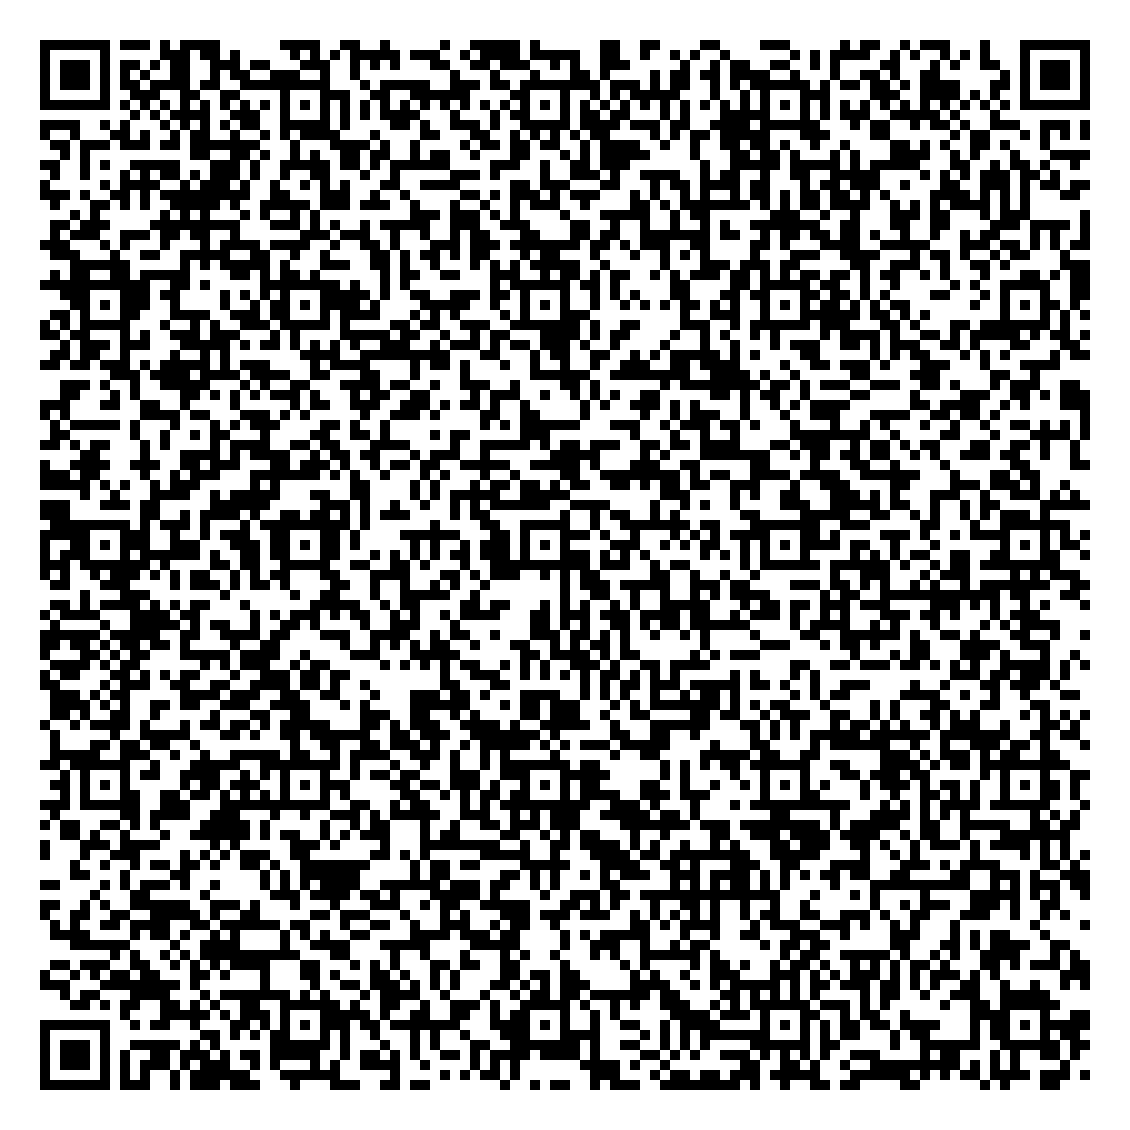

In [100]:
from IPython.display import display

qr = qrcode.QRCode(
    version=22,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
)
qr.add_data(qr_code_data)

img = qr.make_image()
img.save("py_qrcode.png")

display(Image.open("py_qrcode.png"))

### QR Code Scanning

Now let's try and scan the QR Code!

In [101]:
image_data = decode(Image.open('py_qrcode.png'))[0][0]
scannedQR_data  = image_data.decode()

qr_codes_equal = scannedQR_data == qr_code_data

print(f"Are the QR Codes Equal? {qr_codes_equal}")
print(scannedQR_data)

Are the QR Codes Equal? True
shc:/567629595326546034602925407728043360287028647167452228092863360353620834562325344523292852432508320312035626045237643773452425734264040341654531394075704503553042392926552670603122290356432060346029304104366031222909524320603460292437404460573601574533216112667424284350226767563605282771267576686968410572055942686353315940270703762230115634532254704357275734775274713328305366352706107706756562250839064070207159112741373924293045403736047238333221687124521029370412202164535336700673636775754169252543693163076910304429293673112927524006206374230469775754576950351207735472680766265311736732322639412122000531607032625827205232331253664130732441723523427400337328211131047744665521596303713808230054606562705373526773590033006732700642764055632833690930666811745707504406765923127139736338304235652168423454700811563050650353395228741223690355655439650820693421755643283006423723706766362772363352293526691203056368723376732639415460655720390538271070565560210835

### Extracting Data from the QR Code

Now let's reverse the process to get the original data back and check the signature. First, let's extract the JWS.

In [102]:
import re

numeric_chunk = re.findall('.{1,2}', scannedQR_data[5:])
jws_tk = "".join([chr(int(x) + 45) for x in numeric_chunk])
print(jws_tk)

eyJhbGciOiJFUzI1NiIsImtpZCI6IlQ0bk5OeDFOZDJIaXF5M090eG1aRmRvZEFvWm10VnZLTUxsZ0dKWTJGdGsiLCJ0eXAiOiJKV1QiLCJ6aXAiOiJERUYifQ.fZNBj9owEIX_CppeQ2IHtGxyqrqV2u2hWqlbLhUH40yCK8eObCcsXfHfOzawtNIKboPH37z3xnkF5T3UsAth8HVRTEJKZURQ1uSNMBqtEa7JR19ABmbbQs3vlpxxVrFFXrLl4r7KYJJQv8JHaU3AlwD1rzfcfr_P94vcuq4oGb8vpMMGTVBC-2LisMkgHAaMN9boVKvEVuPDWw-NvIB8L1zYodBhl0tS5D-cinksbvapvh-N-pMs3WyUdlINr6Koq8wf4_Y3yhD9tTvlSKWPnBqWOcs58eK_n0bTaIw9Dr0dncTn5ArOBxeXIK3WRDspoQHuQNaJPGr902lquNyvGTVcinfAT2SH7sediB5PENErTTz4ioa4GXRqQhOj_YZtS7rT0HUOmyM53Cpy_1mECONVtZpzNuccjsfsXTn8tpzH_zP2QYTRJ7_9oDFg3NDpZeGDbRJB2kaZLin3Bx-wPz9CWs1Or9KLidEWXjWFnF4IINNNqKqKikb5QYtkd-xwNqBRfnYeAcfNMYPhHFFSS_7RROn_JkxNVsrRpaOYxbOKWULJSj7n5ZyvaNCArrWuR5ekChmsi8jr_Edao5h9ofRNN1tfP5_Zk7OdEz1lSnlrG76P_TZigLFlye6qeHCk318.OcLGK-1ecJM7CfSIppZemN4weI859PIxPaj1kNbmgpG82x8nFtXX982O4KEPh8cDgQj-Cx0cgT64cjsI0r9p-w


Next we can verify the signature and extract the payload

In [103]:
payload = jws.verify(jws_tk, public_key_data, ALGORITHMS.ES256)

# https://bugs.python.org/issue5784
scanned_result = zlib.decompress(payload, wbits=-15).decode()
print(scanned_result)

{"iss":"https://vaccination.danleonard.us/","nbf":1641010903.204389,"vc":{"@context":["https://www.w3.org/2018/credentials/v1"],"type":["VerifiableCredential","https://smarthealth.cards#health-card","https://smarthealth.cards#immunization","https://smarthealth.cards#covid19"],"credentialSubject":{"fhirVersion":"4.0.1","fhirBundle":{"resourceType":"Bundle","type":"collection","entry":[{"fullUrl":"resource:0","resource":{"resourceType":"Patient","name":[{"family":"Henry","given":["Jefferson","V."]}],"birthDate":"1997-10-11"}},{"fullUrl":"resource:1","resource":{"resourceType":"Immunization","status":"completed","vaccineCode":{"coding":[{"system":"http://hl7.org/fhir/sid/cvx","code":"999","display":"Huge penis vaccine"}]},"patient":{"reference":"resource:0"},"occurrenceDateTime":"2021-12-17","performer":[{"actor":{"display":"Intra Gaming Vaccination Program"}}],"lotNumber":"0042069"}}]}}}}


Let's compare this to our original minified payload with whitespace removed

In [104]:
print(scanned_result == no_white_space_health_card)

True


Finally, lets print the entries for easy inspection.

In [105]:
entry = json.loads(scanned_result)["vc"]["credentialSubject"]["fhirBundle"]["entry"]
for item in entry:
    print(json.dumps(item, indent = 4 ))


{
    "fullUrl": "resource:0",
    "resource": {
        "resourceType": "Patient",
        "name": [
            {
                "family": "Henry",
                "given": [
                    "Jefferson",
                    "V."
                ]
            }
        ],
        "birthDate": "1997-10-11"
    }
}
{
    "fullUrl": "resource:1",
    "resource": {
        "resourceType": "Immunization",
        "status": "completed",
        "vaccineCode": {
            "coding": [
                {
                    "system": "http://hl7.org/fhir/sid/cvx",
                    "code": "999",
                    "display": "Huge penis vaccine"
                }
            ]
        },
        "patient": {
            "reference": "resource:0"
        },
        "occurrenceDateTime": "2021-12-17",
        "performer": [
            {
                "actor": {
                    "display": "Intra Gaming Vaccination Program"
                }
            }
        ],
        "lotNu